In [1]:
import msprime
import sys
import numpy as np
import seaborn as sns
from IPython.display import SVG
import matplotlib.pyplot as plt
from itertools import chain
from scipy.stats import truncnorm,expon

In [2]:
#Reference Population
pop_configs = [
    msprime.PopulationConfiguration(sample_size=100)]
recomb = 0.1
Ne = 100
ts_ref = msprime.simulate(
    population_configurations=pop_configs,Ne = Ne,mutation_rate=0.25,recombination_rate = recomb,random_seed=11)
ts_ref.num_mutations

500

In [28]:
def ABCSMC(data,prior_parameter,std,eps,pop_configs,Ne,recomb,N,iterations):
    ref_stat = (data.diversity(),data.Tajimas_D(),data.segregating_sites())
    m_bank = np.zeros((iterations,N))
    w = np.zeros((iterations,N))
    for iteration in range(0,iterations):
        if iteration == 0:
            for i in range(N):
                discrepancy = eps[0]
                while not(discrepancy < eps[0]):
                    m = np.random.exponential(prior_parameter) #sampled mutation rate from prior
                    ts_sim = msprime.simulate(population_configurations=pop_configs,Ne=Ne,recombination_rate=recomb,mutation_rate=m)
                    sim_stat = (ts_sim.diversity(),ts_sim.Tajimas_D(),ts_sim.segregating_sites())
                    discrepancy = np.linalg.norm(np.subtract(ref_stat,sim_stat))
                m_bank[0][i] = m
                w[0][i] = 1/N
        else:
            for i in range(N):
                discrepancy = eps[iteration]
                while not(discrepancy < eps[iteration]):
                    m_sample = float(np.random.choice(m_bank[iteration-1],1,p=np.divide(w[iteration-1],sum(w[iteration-1]))))
                    m_proposal = float(truncnorm.rvs(-m_sample/std,9999999999,size=1))*std + m_sample
                    ts_sim = msprime.simulate(population_configurations=pop_configs,Ne=Ne,recombination_rate=recomb,mutation_rate=m_proposal)
                    sim_stat = (ts_sim.diversity(),ts_sim.Tajimas_D(),ts_sim.segregating_sites())
                    discrepancy = np.linalg.norm(np.subtract(ref_stat,sim_stat))
                m_bank[iteration][i] = m_proposal
                transition_kernel = [truncnorm.pdf(m_bank[iteration][i],-m_proposal/std,9999999999) for i in range(0,N)]
                w[iteration][i] = expon.pdf(m_proposal,scale=prior_parameter)/sum(np.multiply(w[iteration-1],transition_kernel))
    return(m_bank)

In [37]:
%%time
prior_parameter=0.25
N=200
iterations=3
eps=[20,15,10]
std=0.05
attempt1 = ABCSMC(ts_ref,pop_configs=pop_configs,std=std,eps=eps,prior_parameter=prior_parameter,recomb=recomb,Ne=Ne,N=N,iterations=iterations)

Wall time: 4min 29s


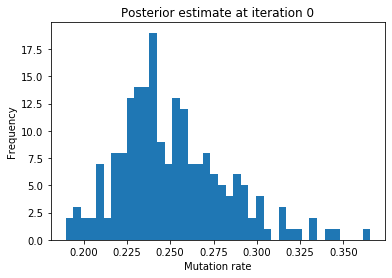

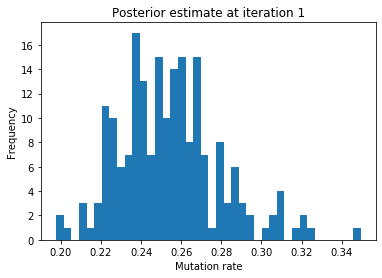

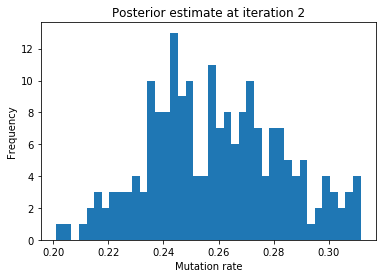

In [43]:
for i in range(0,iterations):
    plt.hist(attempt1[i],bins=40)
    plt.ylabel('Frequency')
    plt.xlabel('Mutation rate')
    plt.title('Posterior estimate at iteration '+str(i))
    plt.show()